### II: Data Pre-processing and EDA

After scraping the data from Reddit in the first notebook, we have to pre-process the text as it is unstructured data. Only then we can start building and training our classification model. 
Steps taken in processing the data are as follows: <br>
1. Combining of Title, Selftext and Comment
2. Tokenizing words: Break sentence into separate words, AKA tokens.
3. Creating a function using Regex to handle cleaning steps
4. Lemmatization 
5. Stopwords removal

Next, EDA was done to understand the data of words better:
1. Wordcloud of common words from each Subreddit
2. Comparison of frequency of N-grams
3. Common words from both Subreddits
4. Volume of posts over time

Lastly, **Sentiment Analysis** using VADER (Valence Aware Dictionary for Sentiment Reasoning) was performed. It aims to measure the sentiments of a speaker/writer based on the computational treatment of subjectivity in a text. VADER is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. For the context of Subreddit posts, I believe VADER would be useful for sentiment analysis.

In [21]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
!nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('punkt')

'nltk.download' is not recognized as an internal or external command,
operable program or batch file.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tiffa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
nvidia = pd.read_csv('datasets/nvidia_reddit.csv',index_col=[0])
amd = pd.read_csv('datasets/amd_reddit.csv',index_col=[0])
print(nvidia.shape)
print(amd.shape)

(21609, 8)
(37520, 8)


#### 1.1 Combining Title, Selftext and Comment columns.
Content in the "Title" and "Selftext" columns are potentially useful for training the model, hence I will get their unique values and append them to the data.

In [23]:
# From the webscraped data, we have 3 text columns - "title", "selftext", "comment". Selftext and titles are repetitive, hence I will get unique values of selftext and title for each Subreddit.
# Rename them as "comment"

title_unique_nv = nvidia.groupby(['Subreddit', 'title']).size().reset_index().rename(columns={'title': 'comment'})
selftext_unique_nv = nvidia.groupby(['Subreddit', 'selftext']).size().reset_index().rename(columns={'selftext': 'comment'})

title_unique_amd = amd.groupby(['Subreddit', 'title']).size().reset_index().rename(columns={'title': 'comment'})
selftext_unique_amd = amd.groupby(['Subreddit', 'selftext']).size().reset_index().rename(columns={'selftext': 'comment'})

In [24]:
# Append these selftext and title columns to main datasets. This is so we retain the data from "title" and "sefltext" column

nvidia = pd.concat([nvidia, title_unique_nv], ignore_index=True).drop(columns=0)
nvidia = pd.concat([nvidia, selftext_unique_nv], ignore_index=True).drop(columns=0)

amd = pd.concat([amd, title_unique_amd], ignore_index=True).drop(columns=0)
amd = pd.concat([amd, selftext_unique_amd], ignore_index=True).drop(columns=0)

# confirm that shape has increased
print(nvidia.shape)
print(amd.shape)

(22504, 8)
(38274, 8)


#### 1.2 Tokenise the words
Tokenising the words means to break up the corpus of text into individual words, hence creating a "bag of words" for us.

In [25]:
# tokenize sentences and words

# Ensure 'comment' column is converted to strings
nvidia['comment'] = nvidia['comment'].apply(lambda x: str(x) if x is not None else "")
amd['comment'] = amd['comment'].apply(lambda x: str(x) if x is not None else "")

# Tokenize sentences and words
nvidia['sentences'] = nvidia['comment'].apply(sent_tokenize)
nvidia['words'] = nvidia['sentences'].apply(lambda x: sum([word_tokenize(sentence) for sentence in x], []))

amd['sentences'] = amd['comment'].apply(sent_tokenize)
amd['words'] = amd['sentences'].apply(lambda x: sum([word_tokenize(sentence) for sentence in x], []))


In [26]:
nvidia['words']

0        [3090, keeps, its, price, from, the, VRAM, it,...
1        [It, 's, not, you, ,, just, a, combo, of, the,...
2        [Starfield, is, CPU, heavy, ,, which, one, do,...
3        [The, game, is, just, awfully, optimized, ., I...
4        [I, tried, using, fsr, but, I, did, n't, see, ...
                               ...                        
22499    [is, their, consensus, on, the, matter, on, te...
22500    [is, there, any, other, way, of, changing, it,...
22501    [my, brother, fucked, around, with, frustratin...
22502    [so, my, gpu, unfortunately, had, an, accident...
22503    [the, question, comes, up, very, often, ., I, ...
Name: words, Length: 22504, dtype: object

In [27]:
amd.words

0        [GPUs, reviewed, in, this, video, :, -, XFX, S...
1        [I, think, they, should, only, use, XT, when, ...
2        [7700xt, is, an, impressive, jump, over, the, ...
3        [They, were, just, following, Nvidias, lead, w...
4        [This, is, the, 100th, comment, on, the, namin...
                               ...                        
38269    [on, B450, all, drivers, are, same, as, of, 5....
38270    [so, i, got, bored, ,, and, now, i, 'm, trying...
38271    [so, ,, i, 've, bought, an, AMD, Ryzen, 5, 360...
38272    [title, says, all, ., When, can, we, see, thre...
38273    [tl, ;, dr, :, curve, optimizer, settings, sta...
Name: words, Length: 38274, dtype: object

#### 1.3 Create a function to clean data using REGEX
Regex is an efficient way to clean data as it automates the processing of locating common patterns in our text and cleaning. In the following function, this cleans the text data and joins them back into a processed string of text that is clean for our model to be trained on.

In [28]:

def preprocessing(word_list):
    # Combine words into a single text
    text = ' '.join(word_list)
    # Remove new lines
    text = text.replace('\n', ' ').lower()
    # Remove emoticons using regular expressions
    text = re.sub(':d', '', text).strip()
    text = re.sub(':p', '', text).strip()
    # Remove HTML markers and punctuation using regular expressions
    text = re.sub('xa0', '', text).strip()
    text = re.sub('x200b', '', text).strip()
    text = re.sub('[^a-zA-Z\s]', '', text).strip()
    # Split the preprocessed text back into a list of words
    preprocessed_words = text.split()
    
    return preprocessed_words

In [29]:
# Apply the preprocessing function and create a new column
nvidia['preprocessed_words'] = nvidia['words'].apply(preprocessing)
nvidia_words_list = nvidia['preprocessed_words'].tolist()
nvidia_words_list = [item for sublist in nvidia_words_list for item in sublist] # flatten the list of list of words

amd['preprocessed_words'] = amd['words'].apply(preprocessing)
amd_words_list = amd['preprocessed_words'].tolist()
amd_words_list = [item for sublist in amd_words_list for item in sublist] # flatten the list of list of words

# convert preprocessed words to a string of text
amd['preprocessed_words'] = amd['preprocessed_words'].apply(lambda words_list: ' '.join(words_list))
nvidia['preprocessed_words'] = nvidia['preprocessed_words'].apply(lambda words_list: ' '.join(words_list))



In [30]:
# Append both datasets as they have the same columns. Can distinguish source data using column "Subreddit".

combine = pd.concat([nvidia,amd], axis = 0)
combine.shape


(60778, 11)

In [31]:
combine.head()

,id,date,title,selftext,n_comments,author,comment,Subreddit,sentences,words,preprocessed_words
0,16d4gg0,2023-09-08 08:04:04,New to pc building,What’s better rtx 3090 for 700$-I’ve seen thes...,1.0,43VerLoner,3090 keeps its price from the VRAM it has. A 4...,Nvidia,"[3090 keeps its price from the VRAM it has., A...","[3090, keeps, its, price, from, the, VRAM, it,...",keeps its price from the vram it has a is a ta...
1,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,"It's not you, just a combo of the game running...",Nvidia,"[It's not you, just a combo of the game runnin...","[It, 's, not, you, ,, just, a, combo, of, the,...",it s not you just a combo of the game running ...
2,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,"Starfield is CPU heavy, which one do you have?...",Nvidia,"[Starfield is CPU heavy, which one do you have...","[Starfield, is, CPU, heavy, ,, which, one, do,...",starfield is cpu heavy which one do you have a...
3,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,The game is just awfully optimized. I just upg...,Nvidia,"[The game is just awfully optimized., I just u...","[The, game, is, just, awfully, optimized, ., I...",the game is just awfully optimized i just upgr...
4,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,I tried using fsr but I didn't see any noticib...,Nvidia,[I tried using fsr but I didn't see any notici...,"[I, tried, using, fsr, but, I, did, n't, see, ...",i tried using fsr but i did nt see any noticib...


#### 1.4 Stopwords Removal

In English, some words appear more frequently than others such as "is", "a", "the", "and". As they appear often, the NLTK package "english words" flag them out as common stopwords. They are filtered out so as that our analysis can focus on more meaningful words.

In [55]:
# Remove Stopwords
custom_stopwords = [ "subreddit", "reddit"]  # remove these words as it is not meaningful for our analysis
stopwords_list = set(stopwords.words('english') + custom_stopwords)

In [33]:
# Save it in Dataframe
nv_words_list_cleaned = [token for token in nvidia_words_list if token not in stopwords_list]
amd_words_list_cleaned = [token for token in amd_words_list if token not in stopwords_list]

#### 1.5 Lemmatization

Lemmatization is derive from lemma, and the lemma of a word corresponds to its dictionary form. Hence, the goal is to reduce words to its root form. For example, the lemmatization algorithm would transform the word "better" into its root word, "good". <br>
Hence, it is useful for cases where understanding the meaning of dialogue is important. It helps for more meaningful data processing and analysis.

In [34]:
# create a function for lemmatization
def lemmatization(text):
    words = text.split(' ')
    lemmatizer = WordNetLemmatizer() #instatntiate
    meaningful_output = [lemmatizer.lemmatize(w) for w in words if w not in stopwords_list]

    return(" ".join(meaningful_output)) # join words back into a string

In [35]:
# run function to lemmatize

combine['preprocessed_words'] = combine['preprocessed_words'].apply(lemmatization,True)

C:\Users\tiffa\AppData\Local\Temp\ipykernel_13816\2758187641.py:3: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  combine['preprocessed_words'] = combine['preprocessed_words'].apply(lemmatization,True)


#### 2.1 Wordcloud

I will generate 2 wordclouds from each Subreddit to compare the common words. The size of the word indicates its frequency of occurrence.

In [36]:
# Create word clouds
# pip install wordcloud
from wordcloud import WordCloud

wordcloud1 = WordCloud(width=400, height=400, background_color='white').generate(' '.join(nv_words_list_cleaned))
wordcloud2 = WordCloud(width=400, height=400, background_color='white').generate(' '.join(amd_words_list_cleaned))

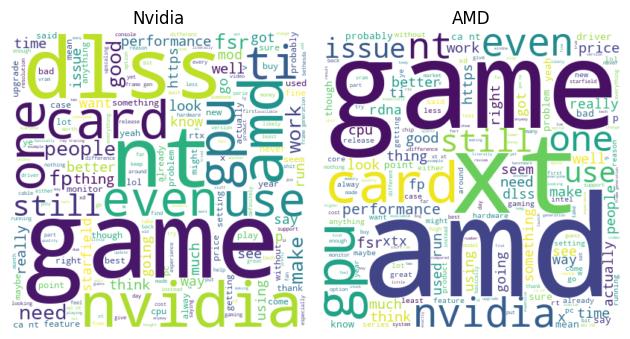

In [37]:
# Plot the first word cloud on the left
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Nvidia')
plt.axis('off')

# Plot the second word cloud on the right
plt.subplot(1, 2, 2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('AMD')
plt.axis('off')
plt.tight_layout()
plt.show()

#### 2.2 Analysing N-grams

N-grams are continuous sequence of words in a document, where N-gram represents a sequence of N-words. This helps us to understand common co-occurring words in the Subreddits. Some N-grams might be more meaningful when doing text analysis, especially sentiment analysis. For instance, a one-gram "good" vs a bi-gram "not good" are polar opposites. 

In [38]:
(pd.Series(nltk.ngrams(nv_words_list_cleaned, 3)).value_counts())[:10]


(width, formatpjpg, autowebp)    85
(dlss, frame, generation)        85
(dlss, frame, gen)               75
(nvidia, control, panel)         74
(dlss, super, resolution)        63
(width, formatpng, autowebp)     60
(ca, nt, even)                   46
(ca, nt, run)                    32
(p, hz, monitor)                 30
(dlss, ray, reconstruction)      30
Name: count, dtype: int64

In [39]:
onegram_series_nv = (pd.Series(nltk.ngrams(nv_words_list_cleaned, 1)).value_counts())[:20]
bigrams_series_nv = (pd.Series(nltk.ngrams(nv_words_list_cleaned, 2)).value_counts())[:20]
trigrams_series_nv = (pd.Series(nltk.ngrams(nv_words_list_cleaned, 3)).value_counts())[:20]
onegram_series_amd = (pd.Series(nltk.ngrams(amd_words_list_cleaned, 1)).value_counts())[:20]
bigrams_series_amd = (pd.Series(nltk.ngrams(amd_words_list_cleaned, 2)).value_counts())[:20]
trigrams_series_amd = (pd.Series(nltk.ngrams(amd_words_list_cleaned, 3)).value_counts())[:20]

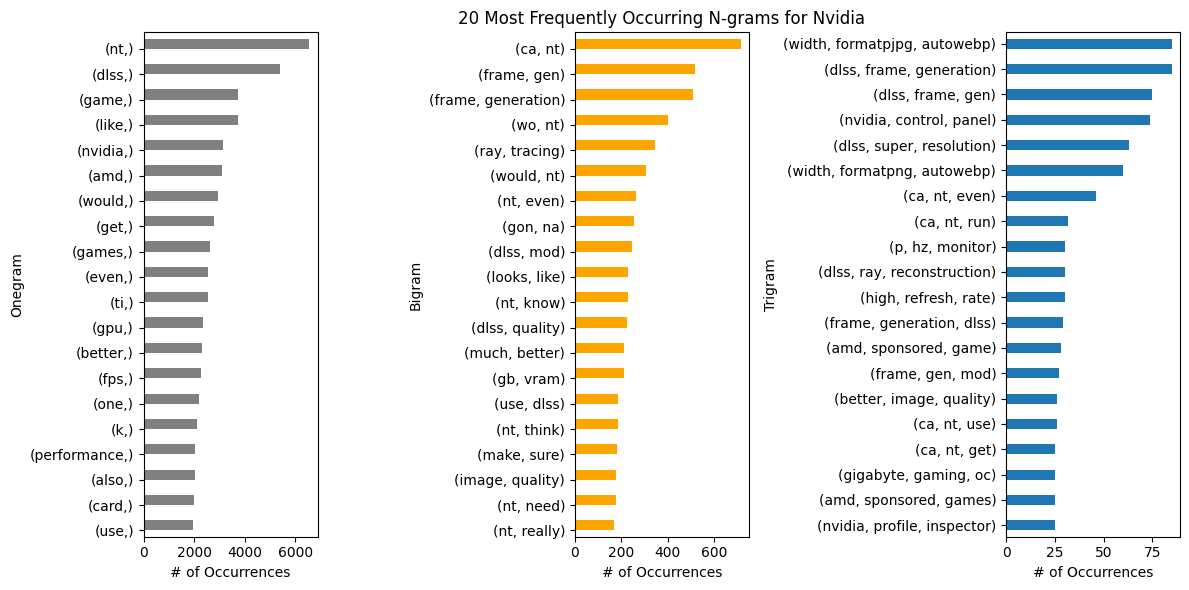

In [40]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))

# Plot bigrams on the left subplot
onegram_series_nv.sort_values().plot.barh(color='grey', width=0.4, ax=axes[0], align='edge')
# axes[0].set_title('20 Most Frequently Occurring Onegrams for Nvidia')
axes[0].set_ylabel('Onegram')
axes[0].set_xlabel('# of Occurrences')

# Plot bigrams on the left subplot
bigrams_series_nv.sort_values().plot.barh(color='orange', width=0.4, ax=axes[1], align='edge')
axes[1].set_title('20 Most Frequently Occurring N-grams for Nvidia')
axes[1].set_ylabel('Bigram')
axes[1].set_xlabel('# of Occurrences')

# Plot trigrams on the right subplot
trigrams_series_nv.sort_values().plot.barh( width=0.4, ax=axes[2])
# axes[2].set_title('20 Most Frequently Occurring Trigrams for Nvidia')
axes[2].set_ylabel('Trigram')
axes[2].set_xlabel('# of Occurrences')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

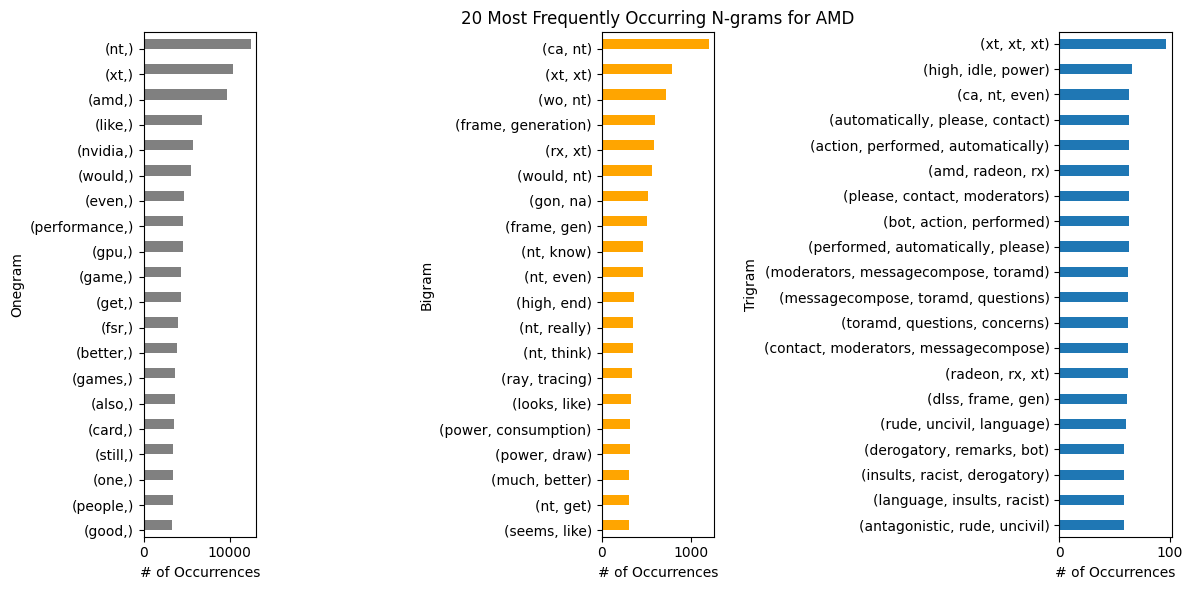

In [41]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))

# Plot bigrams on the left subplot
onegram_series_amd.sort_values().plot.barh(color='grey', width=0.4, ax=axes[0], align='edge')
# axes[0].set_title('20 Most Frequently Occurring Onegrams for Nvidia')
axes[0].set_ylabel('Onegram')
axes[0].set_xlabel('# of Occurrences')

# Plot bigrams on the left subplot
bigrams_series_amd.sort_values().plot.barh(color='orange', width=0.4, ax=axes[1], align='edge')
axes[1].set_title('20 Most Frequently Occurring N-grams for AMD')
axes[1].set_ylabel('Bigram')
axes[1].set_xlabel('# of Occurrences')

# Plot trigrams on the right subplot
trigrams_series_amd.sort_values().plot.barh( width=0.4, ax=axes[2])
# axes[2].set_title('20 Most Frequently Occurring Trigrams for Nvidia')
axes[2].set_ylabel('Trigram')
axes[2].set_xlabel('# of Occurrences')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

##### 2.2.1 Analysis of N-grams 

Popular N-Grams for Nvidia:
- **dlss (DLSS)**: Deep Learning Super Sampling - deep learning neural technology developed by Nvidia and is exclusive to the RTX line of graphic cards. Boosts frame rates and generates sharp images.
- **ti**: Generally higher end Nvidia graphics card, e.g. Nvidia RTX 4080 vs Nvidia RTX 4080 Ti (higher-end)
- **(high, refresh, rate), (better, image, quality)**: these trigrams seem to be a result of satisfied users. To be further investigated during sentiment analysis.

Popular N-Grams for AMD:
- **xt (XT)**:  AMD uses the suffix 'XT' to designate their higher-end GPUs. For eg. 6800xt, 6700xt
- **fsr**: AMD's technology FidelityFX™ Super Resolution (FSR), which is AMD's answer to Nvidia's DLSS
- **(please, contact, moderators), (rude, uncivil, language), (racist, derogatory, bot)**: these trigrams were unique to AMD subreddits and are probably a result of very unhappy users. This can be further investigated using a Sentiment Analysis.

Popular words for Both:
- **gpu**: Graphics Processing Unit - typically used in the community to refer to the graphics card, which is what Nvidia and AMD manufacture.
- **game**: Products of Nvidia and AMDs like graphic cards are very important for gamers.
- **Nvidia, AMD**: As expected, both names appeared in both subreddits as these companies are competitors in manufacturing graphics cards. Hence, users would be comparing products from both companies in their reddits.



##### 2.2.2 Analysis of "Wo, Nt", "Ca, Nt", "Gon, na"

In both frequency bar charts, the words "wo, nt" and "ca, nt" appear quite often. My guess is that these actually mean "won't", "can;t" and "gonna". I will filter for rows that contain these strings to confirm my suspicion.

In [42]:
combine_filtered = combine[combine["preprocessed_words"].str.contains("ca nt")]
combine_filtered = pd.DataFrame(combine_filtered)
combine_filtered['preprocessed_words']

49         yes would consider plugged flush ca nt anything
65       think supposed able look like http iimgurcomzp...
130      ca nt access bios either msi b edge beta eeams...
195      nt get mentality acting like dl negative thing...
251      feel like people purist graphic nt like consid...
                               ...                        
38203    rdna specifically mcm gpus bold design choice ...
38207    really rough go optimizing co used slow way lo...
38216    since seems little information laptop u though...
38227    right position make somewhat hard differentiat...
38252    wrong naming scemes xtx xt xt xt xt xt aside n...
Name: preprocessed_words, Length: 1775, dtype: object

Seems like indeed these words are  cant, wont and gonna. Using this knowledge, I will join them back as strings to ensure that my corpus of text used to train my model later is more accurate.

In [43]:
combine['preprocessed_words'] = combine['preprocessed_words'].str.replace("ca nt", "cant").str.replace("wo nt", "wont").str.replace("gon na", "gonna")


#### 2.3 Common Words from both AMD and Nvidia Subreddits

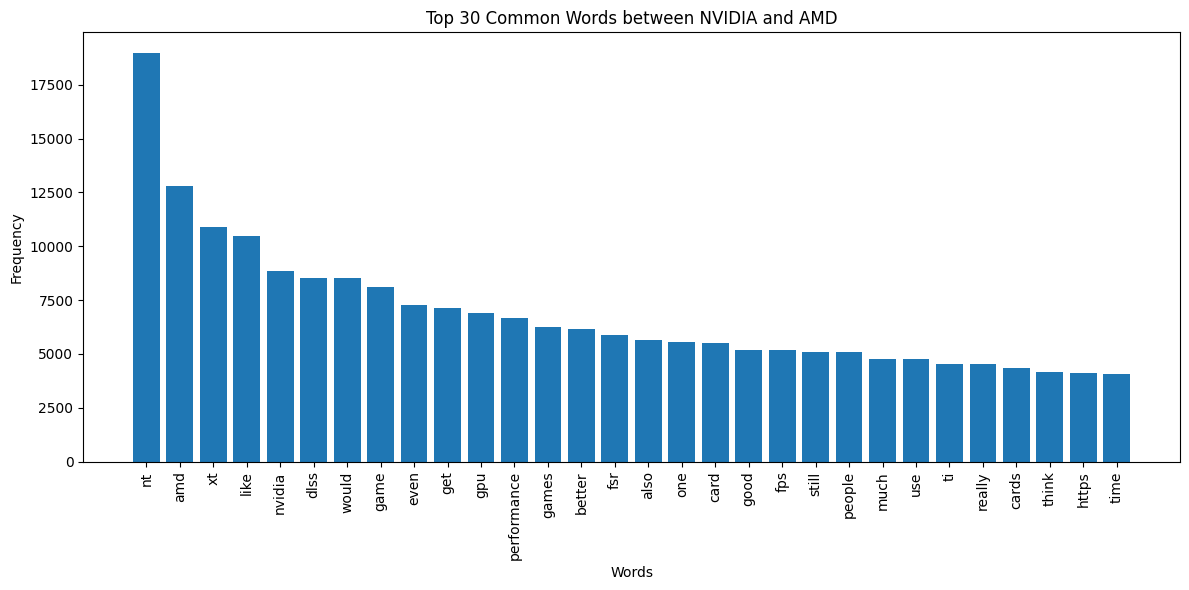

In [44]:

from collections import Counter


nv_words_set = set(nv_words_list_cleaned)
amd_words_set = set(amd_words_list_cleaned)

common_words = nv_words_set.intersection(amd_words_set)

nv_word_counts = Counter(nv_words_list_cleaned)
amd_word_counts = Counter(amd_words_list_cleaned)

# Calculate word frequencies for common words
common_word_frequencies = {word: nv_word_counts[word] + amd_word_counts[word] for word in common_words}

# Sort the common words by frequency in descending order
top_common_words = sorted(common_word_frequencies.items(), key=lambda x: x[1], reverse=True)[:30]

# Extract the words and frequencies for plotting
top_common_words, top_common_word_frequencies = zip(*top_common_words)

plt.figure(figsize=(12, 6)) 
plt.bar(top_common_words, top_common_word_frequencies)
plt.title('Top 30 Common Words between NVIDIA and AMD')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()



These common words are words overlapping both subreddits. During modelling, I will explore if removing these common words (in addition to the common english stopwords) will be useful in improving model performance. By removing them, I am retaining the words that are more specific to the content of each subreddit. This might enhances the model's ability to capture the distinctive language and topics associated with each community.

In [45]:
# export common words to csv
top_common_words_df = pd.DataFrame(top_common_words)
top_common_words_df.to_csv('datasets/common_words.csv')

In [46]:
# export combined dataset as csv
combine.to_csv('datasets/combined.csv')

#### 2.4 Volume of Posts over Time
Let's see if there are any trends in changes in volume of posts over time. For example, if there might be any days with a spike in posts.

In [47]:
# Convert 'datetime' column to datetime type

df_grouped = combine.groupby(['Subreddit','date']).size().reset_index(name='post_count')
df_grouped['date_column'] = pd.to_datetime(df_grouped['date'])

# Extract the date component
df_grouped['date_column'] = df_grouped['date_column'].dt.date

c:\Users\tiffa\Documents\DSIF-SG-11\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffa\Documents\DSIF-SG-11\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffa\Documents\DSIF-SG-11\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffa\Documents\DSIF-SG-11\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

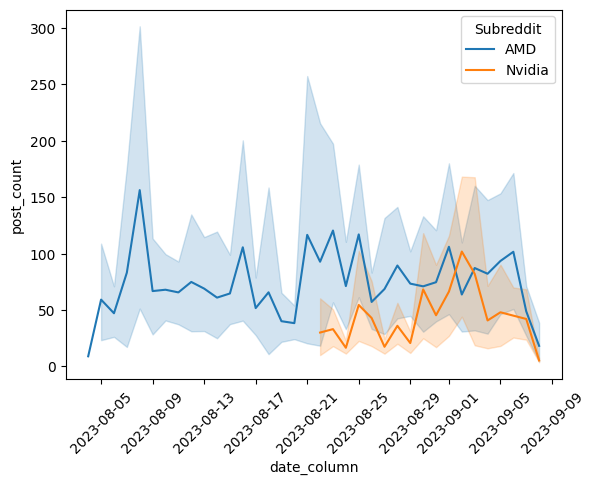

In [48]:
sns.lineplot(data=df_grouped, x="date_column", y="post_count", hue="Subreddit")
plt.xticks(rotation=45) 
plt.show()

There seems to be no distinct trend in volume of comments. However, for the same number of posts (500 posts scraped), AMD posts had a lot more comments - perhaps AMD users were more vocal about their sentiments.

#### 2.5 Number of Comments per post
The data that I have scraped from notebook 1 includes "Title", "Selftext" and "Comments". For each subreddit post, there is one title, and can have multiple comments. Let's see if there is a difference in number of replies/comments per post.

In [56]:
combine.columns

Index(['id', 'date', 'title', 'selftext', 'n_comments', 'author', 'comment',
       'Subreddit', 'sentences', 'words', 'preprocessed_words',
       'comments_no_stopwords', 'scores'],
      dtype='object')

In [58]:
df_grouped = combine.groupby(['Subreddit','title']).size().reset_index(name='num_of_comments')
df_grouped

,Subreddit,title,num_of_comments
0,AMD,"""# of Supported displays"" for AMD APUs",15
1,AMD,"""Gaming"" Preset on AMD Software while not Playing",12
2,AMD,"""Smart Access Memory is the same thing as ReBAR""",80
3,AMD,$200 Graphics Cards - Were older cards better?...,78
4,AMD,(RX 6700XT) Asus Dual vs XFX Swft 309 Vs Sapph...,31
...,...,...,...
962,Nvidia,rtx 3070 or rtx 2080 ti?,8
963,Nvidia,upgrade gpu,11
964,Nvidia,what do the numbers mean,1
965,Nvidia,what is the 4060s (laptop version) desktop equ...,3


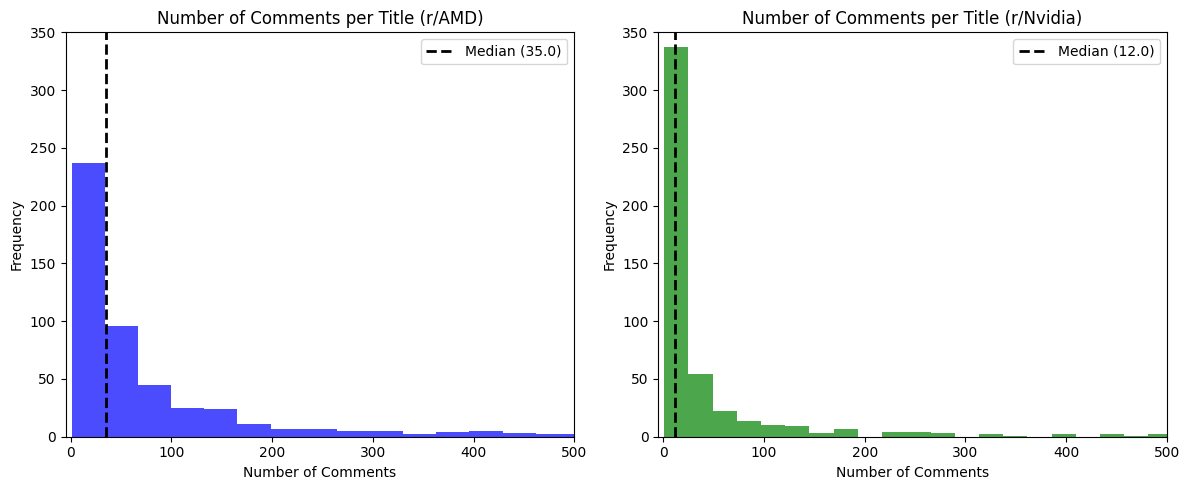

In [82]:

# Filter the DataFrame for the AMD and Nvidia subreddits
amd_data = df_grouped[df_grouped['Subreddit'] == 'AMD']
nvidia_data = df_grouped[df_grouped['Subreddit'] == 'Nvidia']

# Create histograms for the number of comments per title
plt.figure(figsize=(12, 5))

# Histogram for AMD subreddit
plt.subplot(1, 2, 1)
plt.hist(amd_data['num_of_comments'], bins=30, color='blue', alpha=0.7)
plt.title('Number of Comments per Title (r/AMD)')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')

median_amd = amd_data['num_of_comments'].median()
plt.axvline(median_amd, color='black', linestyle='dashed', linewidth=2, label=f'Median ({median_amd})')
plt.legend()

# Customize the y-axis limits if needed
plt.ylim(0, 350)
plt.xlim(-5, 500)

# Histogram for Nvidia subreddit
plt.subplot(1, 2, 2)
plt.hist(nvidia_data['num_of_comments'], bins=30, color='green', alpha=0.7)
plt.title('Number of Comments per Title (r/Nvidia)')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')

median_nvidia = nvidia_data['num_of_comments'].median()
plt.axvline(median_nvidia, color='black', linestyle='dashed', linewidth=2, label=f'Median ({median_nvidia})')
plt.legend()

# Customize the y-axis limits if needed
plt.ylim(0, 350)
plt.xlim(-5, 500)


plt.tight_layout()
plt.show()


The subreddit posts in AMD had a much higher number of comments per post. This might mean netizens were more passionate about posting their views on certain topics. Typically, I'd imagine it is because they are complaining about certain issues. This will be further explored in the next topic of Sentiment Analysis.

In [85]:
# View posts with top comments for AMD
sorted_amd = amd_data.sort_values(by='num_of_comments', ascending=False)
sorted_amd.head(10)

,Subreddit,title,num_of_comments
434,AMD,What are AMD's answers to DLSS 2/3 and 3.5?,988
444,AMD,What's with all the hate for RDNA3 on this sub?,771
80,AMD,AMD Radeon RX 7800 XT GPU Review & Benchmarks ...,712
110,AMD,AMD denies blocking Bethesda from adding DLSS ...,576
101,AMD,AMD Software: Adrenalin Edition 23.8.1 Release...,576
57,AMD,"AMD FidelityFX Super Resolution 3 (FSR3) is ""c...",508
220,AMD,First Look at AMD FidelityFX Super Resolution 3,507
351,AMD,RX 6800 positive experience makes AMD GPU's ha...,489
114,AMD,AMD fix high idle power PLEASE,464
106,AMD,AMD announces Radeon RX 7800 XT 16GB and RX 77...,459


In [86]:
# View posts with top comments for Nvidia
sorted_nvidia = nvidia_data.sort_values(by='num_of_comments', ascending=False)
sorted_nvidia.head(10)

,Subreddit,title,num_of_comments
835,Nvidia,Starfield Frame Generation Is Here! Thanks to ...,722
716,Nvidia,"John Linneman (Digital Foundry) ""What I can sa...",707
833,Nvidia,Starfield DLSS/XeSS mod is out in less than 2 ...,587
852,Nvidia,The 1st and 6th most downloaded mods for Starf...,571
593,Nvidia,Confirmed: Starfield Doesn’t Support Nvidia DL...,569
832,Nvidia,"Starfield DLSS 3.5 Mod Now Available On PC, Up...",505
551,Nvidia,AMD claims there’s nothing stopping Starfield ...,486
829,Nvidia,Star Wars: Jedi Survivor new Patch 7 adds DLSS...,478
645,Nvidia,"GPU Marketshare in Q2 2023: NVIDIA 87%, AMD 10...",443
574,Nvidia,Buy 4090 or wait?,439


As expected, it seems that the top comments for AMD seem more negative than in Nvidia.

#### 3. Sentiment Analysis

VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in these 4 categories: 
1) Negative
2) Neutral
3) Positive
4) Compound (computed by normalizing the scores above)

Explain why VADER is chosen
https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

In [49]:
# Instantiate Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()
combine.head()

,id,date,title,selftext,n_comments,author,comment,Subreddit,sentences,words,preprocessed_words
0,16d4gg0,2023-09-08 08:04:04,New to pc building,What’s better rtx 3090 for 700$-I’ve seen thes...,1.0,43VerLoner,3090 keeps its price from the VRAM it has. A 4...,Nvidia,"[3090 keeps its price from the VRAM it has., A...","[3090, keeps, its, price, from, the, VRAM, it,...",keep price vram tad slower access frame genera...
1,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,"It's not you, just a combo of the game running...",Nvidia,"[It's not you, just a combo of the game runnin...","[It, 's, not, you, ,, just, a, combo, of, the,...",combo game running like pig older gpu showing ...
2,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,"Starfield is CPU heavy, which one do you have?...",Nvidia,"[Starfield is CPU heavy, which one do you have...","[Starfield, is, CPU, heavy, ,, which, one, do,...",starfield cpu heavy one great ti gpu probably ...
3,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,The game is just awfully optimized. I just upg...,Nvidia,"[The game is just awfully optimized., I just u...","[The, game, is, just, awfully, optimized, ., I...",game awfully optimized upgraded ti like month ...
4,16d46z5,2023-09-08 07:47:35,Experiences,I personally play on a typical 1080ti system(...,7.0,SEALEJ2001,I tried using fsr but I didn't see any noticib...,Nvidia,[I tried using fsr but I didn't see any notici...,"[I, tried, using, fsr, but, I, did, n't, see, ...",tried using fsr nt see noticible improvement w...


In [50]:
print(combine.shape)
combine['comment']

(60778, 11)


0        3090 keeps its price from the VRAM it has. A 4...
1        It's not you, just a combo of the game running...
2        Starfield is CPU heavy, which one do you have?...
3        The game is just awfully optimized. I just upg...
4        I tried using fsr but I didn't see any noticib...
                               ...                        
38269    on B450 all drivers are same as of 5.05.16.529...
38270    so i got bored, and now i'm trying the shark b...
38271    so, i've bought an AMD Ryzen 5 3600 (used) and...
38272    title says all. When can we see threads reques...
38273    tl;dr: curve optimizer settings stay in place ...
Name: comment, Length: 60778, dtype: object

In [51]:
# Adding scores and labels to dataframe
combine['comments_no_stopwords'] = combine['comment'].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stopwords_list]))
combine['scores'] = combine['comments_no_stopwords'].apply(lambda review: sid.polarity_scores(review)) 
sentiment_df = combine[['Subreddit','comment','scores']]

In [52]:
# Create separate column "Compound" and "Compound_Score". All values > 0 will be considered a positive review and all values < 0 would be considered as a negative review.

sentiment_df['compound']  = sentiment_df['scores'].apply(lambda score_dict: score_dict['compound'])
sentiment_df['compound_score'] = sentiment_df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
sentiment_df['is_amd'] = sentiment_df['Subreddit'].apply(lambda x: 1 if x == "AMD" else 0)
sentiment_df.head()

C:\Users\tiffa\AppData\Local\Temp\ipykernel_13816\3044032083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['compound']  = sentiment_df['scores'].apply(lambda score_dict: score_dict['compound'])
C:\Users\tiffa\AppData\Local\Temp\ipykernel_13816\3044032083.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['compound_score'] = sentiment_df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
C:\Users\tiffa\AppData\Local\Temp\ipykernel_13816\3044032083.py:5: SettingWithCopyWar

,Subreddit,comment,scores,compound,compound_score,is_amd
0,Nvidia,3090 keeps its price from the VRAM it has. A 4...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,0
1,Nvidia,"It's not you, just a combo of the game running...","{'neg': 0.0, 'neu': 0.902, 'pos': 0.098, 'comp...",0.3612,pos,0
2,Nvidia,"Starfield is CPU heavy, which one do you have?...","{'neg': 0.0, 'neu': 0.823, 'pos': 0.177, 'comp...",0.6249,pos,0
3,Nvidia,The game is just awfully optimized. I just upg...,"{'neg': 0.08, 'neu': 0.773, 'pos': 0.147, 'com...",0.3804,pos,0
4,Nvidia,I tried using fsr but I didn't see any noticib...,"{'neg': 0.158, 'neu': 0.428, 'pos': 0.414, 'co...",0.8316,pos,0


In [53]:
# Write a review as one continuous string to test sentiment analyzer
review = 'AMD is bad.'
# Obtain the sid scores for your review
sid.polarity_scores(review)

{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}

##### 3.1 Plotting of Sentiment Analysis Results

c:\Users\tiffa\Documents\DSIF-SG-11\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffa\Documents\DSIF-SG-11\.conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tiffa\Documents\DSIF-SG-11\.conda\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffa\Documents\DSIF-SG-11\.conda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

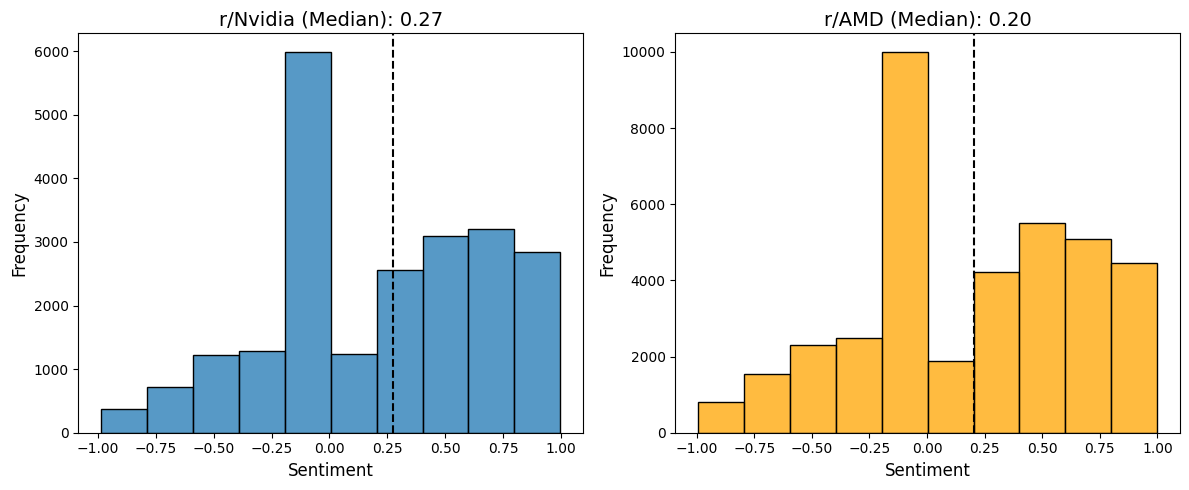

In [54]:
# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Extract data for Nvidia and AMD subreddits
nvidia_data = sentiment_df[sentiment_df['Subreddit'] == 'Nvidia']['compound']
amd_data = sentiment_df[sentiment_df['Subreddit'] == 'AMD']['compound']

# Plot histograms for Nvidia and AMD
sns.histplot(nvidia_data, ax=axes[0],  bins=10)
sns.histplot(amd_data, ax=axes[1], color='orange', bins=10)

# Calculate and annotate median values
median_nvidia = nvidia_data.median()
median_amd = amd_data.median()
axes[0].axvline(median_nvidia, color='black', linestyle='--', label=f'Median: {median_nvidia:.2f}')
axes[1].axvline(median_amd, color='black', linestyle='--', label=f'Median: {median_amd:.2f}')

# Set titles and labels
axes[0].set_title(f'r/Nvidia (Median): {(median_nvidia):.2f}', fontsize=14)
axes[1].set_title(f'r/AMD (Median): {(median_amd):.2f}', fontsize=14)
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[1].set_xlabel('Sentiment', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


Overall it seems like both subreddits and a median positive sentiment score. However, it can be seen that the median sentiment score for AMD is lower at 0.20 (vs Nvidia's 0.27). Hence meaning less positive sentiments in the AMD subreddit forums.